In [1]:
import pandas as pd

df = pd.read_csv('/content/shopping_behavior_updated.csv')
display(df.head())

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [3]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Check for anomalies in numerical columns
display(df.describe())

Number of duplicate rows: 0


,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [4]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Print unique values for each categorical column
for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("-" * 30)

Unique values in 'Gender':
['Male' 'Female']
------------------------------
Unique values in 'Item Purchased':
['Blouse' 'Sweater' 'Jeans' 'Sandals' 'Sneakers' 'Shirt' 'Shorts' 'Coat'
 'Handbag' 'Shoes' 'Dress' 'Skirt' 'Sunglasses' 'Pants' 'Jacket' 'Hoodie'
 'Jewelry' 'T-shirt' 'Scarf' 'Hat' 'Socks' 'Backpack' 'Belt' 'Boots'
 'Gloves']
------------------------------
Unique values in 'Category':
['Clothing' 'Footwear' 'Outerwear' 'Accessories']
------------------------------
Unique values in 'Location':
['Kentucky' 'Maine' 'Massachusetts' 'Rhode Island' 'Oregon' 'Wyoming'
 'Montana' 'Louisiana' 'West Virginia' 'Missouri' 'Arkansas' 'Hawaii'
 'Delaware' 'New Hampshire' 'New York' 'Alabama' 'Mississippi'
 'North Carolina' 'California' 'Oklahoma' 'Florida' 'Texas' 'Nevada'
 'Kansas' 'Colorado' 'North Dakota' 'Illinois' 'Indiana' 'Arizona'
 'Alaska' 'Tennessee' 'Ohio' 'New Jersey' 'Maryland' 'Vermont'
 'New Mexico' 'South Carolina' 'Idaho' 'Pennsylvania' 'Connecticut' 'Utah'
 'Virginia' 'Ge

In [5]:
from datetime import datetime, timedelta

# Create a dummy date column for calculations, assuming each row is a purchase event
# We'll assume the data spans a period of time, and the last date in the dataset is the reference date.
# For simplicity, let's assign a sequential date starting from an arbitrary date for each customer's purchases.

# Sort by Customer ID to process purchases in order
df_sorted = df.sort_values(by='Customer ID')

# Assign a dummy date for each purchase for each customer
start_date = datetime(2023, 1, 1)
df_sorted['PurchaseDate'] = df_sorted.groupby('Customer ID').cumcount().apply(lambda x: start_date + timedelta(days=x))

# Define the reference date as the latest dummy purchase date in the dataset
reference_date = df_sorted['PurchaseDate'].max() + timedelta(days=1)

# Calculate Recency (R)
recency_df = df_sorted.groupby('Customer ID')['PurchaseDate'].max().reset_index()
recency_df['Recency'] = (reference_date - recency_df['PurchaseDate']).dt.days

# Calculate Frequency (F)
frequency_df = df_sorted.groupby('Customer ID').size().reset_index(name='Frequency')

# Calculate Monetary (M)
monetary_df = df_sorted.groupby('Customer ID')['Purchase Amount (USD)'].sum().reset_index(name='Monetary')

# Calculate Average Order Value (AOV)
aov_df = df_sorted.groupby('Customer ID').agg(
    TotalSpent=('Purchase Amount (USD)', 'sum'),
    NumPurchases=('Customer ID', 'count')
).reset_index()
aov_df['AOV'] = aov_df['TotalSpent'] / aov_df['NumPurchases']

# Calculate Tenure
tenure_df = df_sorted.groupby('Customer ID')['PurchaseDate'].min().reset_index()
tenure_df['Tenure'] = (reference_date - tenure_df['PurchaseDate']).dt.days

# Merge the calculated features into a single DataFrame
customer_features = recency_df[['Customer ID', 'Recency']].merge(
    frequency_df, on='Customer ID'
).merge(
    monetary_df, on='Customer ID'
).merge(
    aov_df[['Customer ID', 'AOV']], on='Customer ID'
).merge(
    tenure_df[['Customer ID', 'Tenure']], on='Customer ID'
)

display(customer_features.head())

# Define customer cohorts based on the first purchase date (using the dummy date for now)
df_sorted['Cohort'] = df_sorted.groupby('Customer ID')['PurchaseDate'].transform('min').dt.to_period('M')

display(df_sorted.head())

,Customer ID,Recency,Frequency,Monetary,AOV,Tenure
0,1,1,1,53,53.0,1
1,2,1,1,64,64.0,1
2,3,1,1,73,73.0,1
3,4,1,1,90,90.0,1
4,5,1,1,49,49.0,1


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,PurchaseDate,Cohort
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,2023-01-01,2023-01
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,2023-01-01,2023-01
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,2023-01-01,2023-01
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly,2023-01-01,2023-01
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually,2023-01-01,2023-01


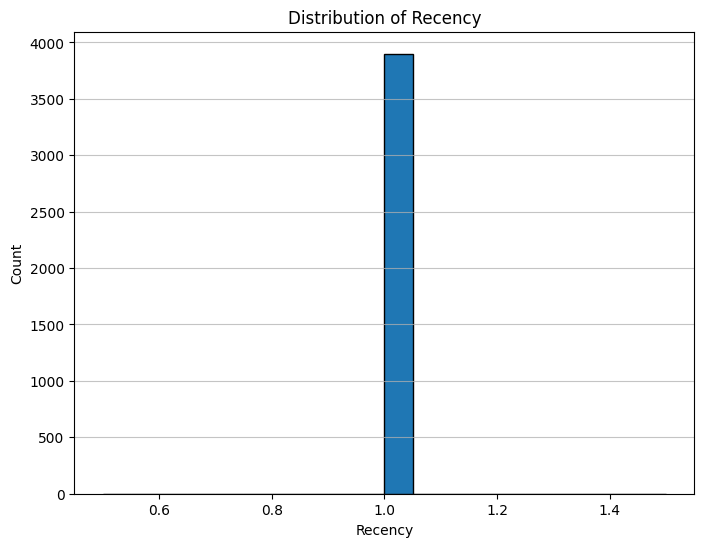

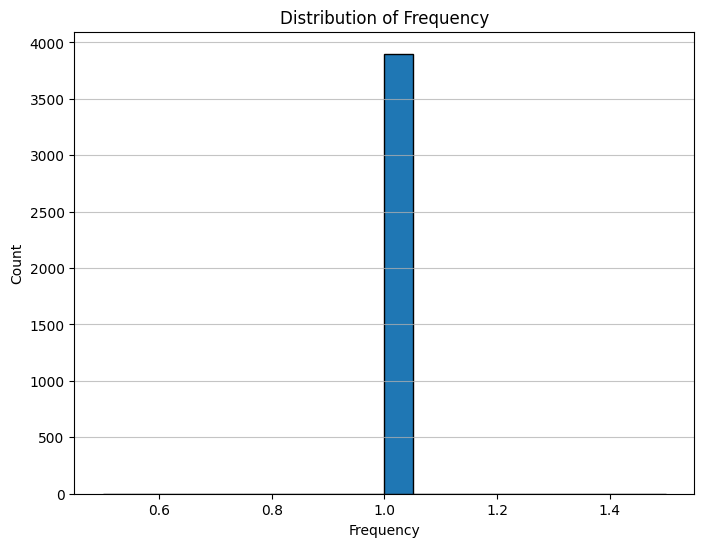

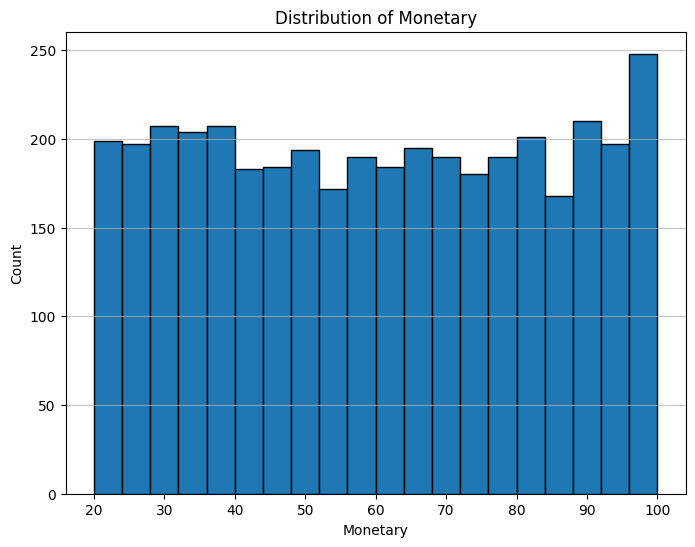

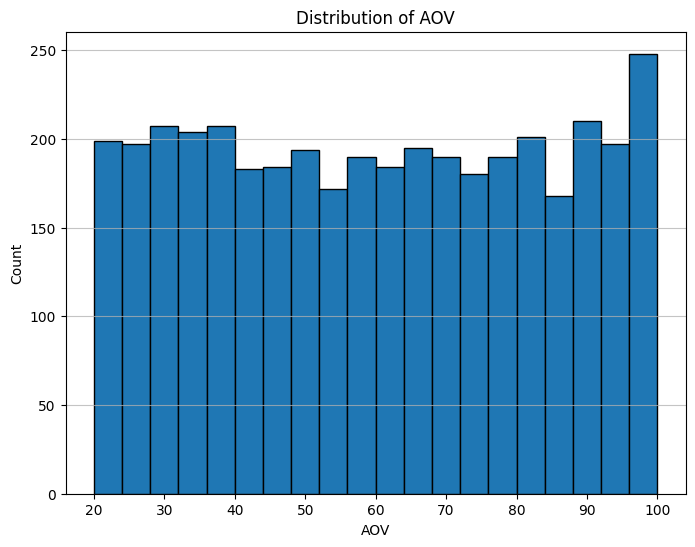

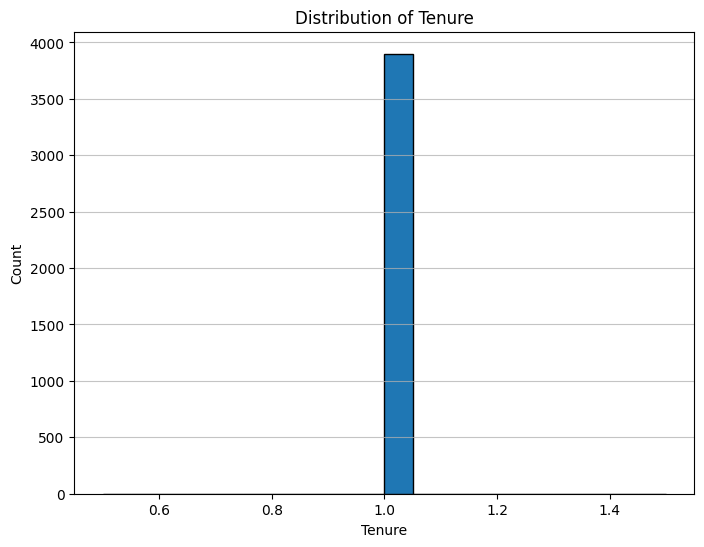

In [6]:
import matplotlib.pyplot as plt

numerical_cols = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(customer_features[col], bins=20, edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

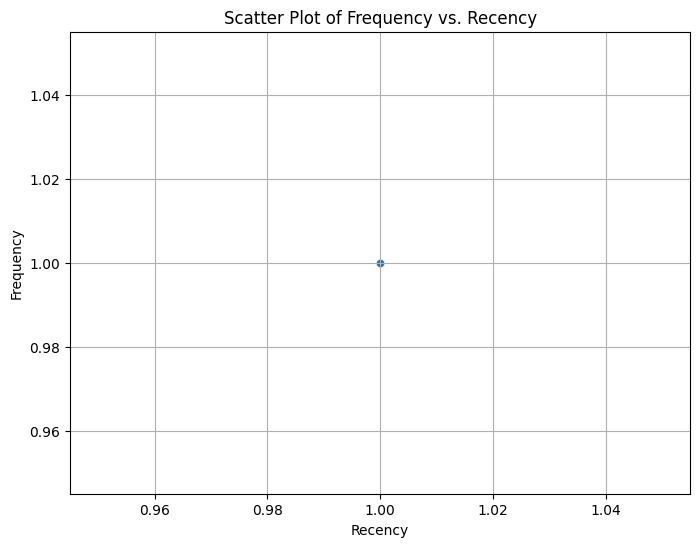

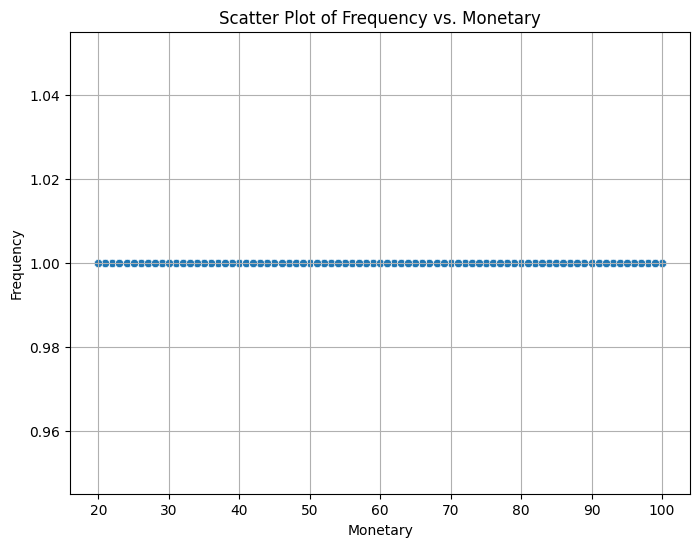

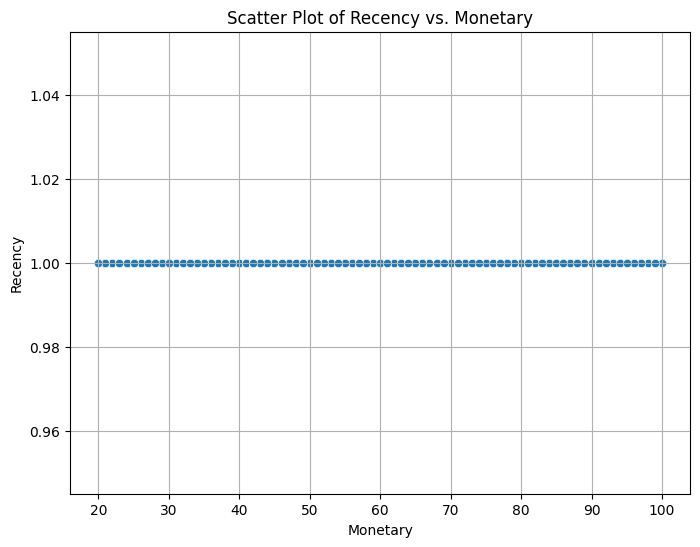

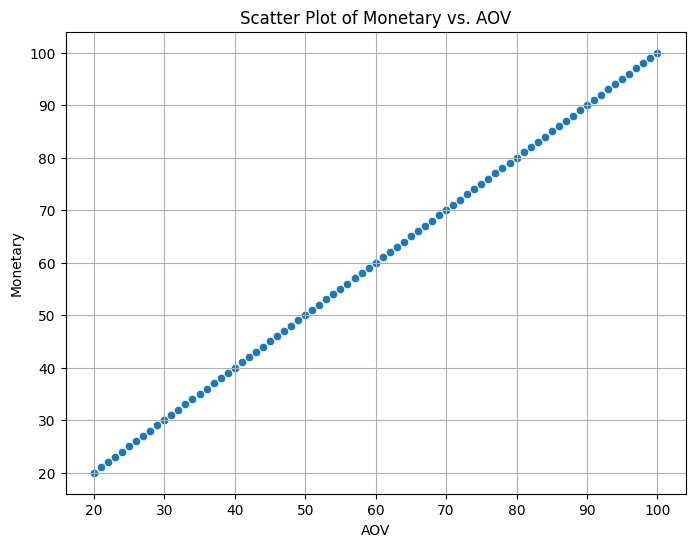

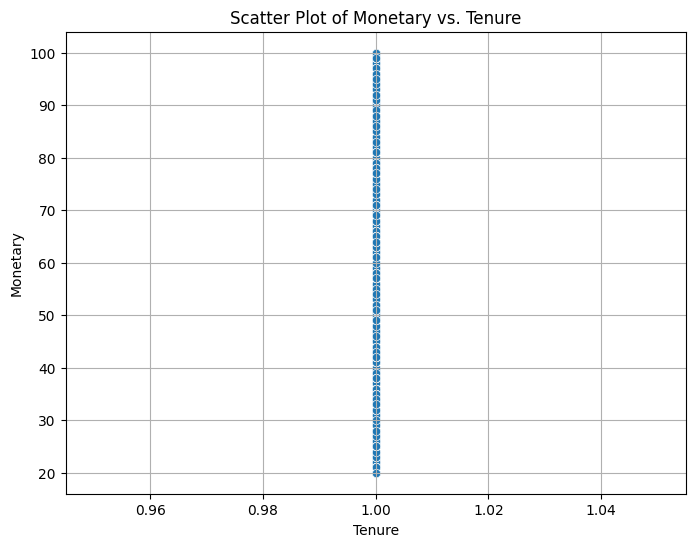

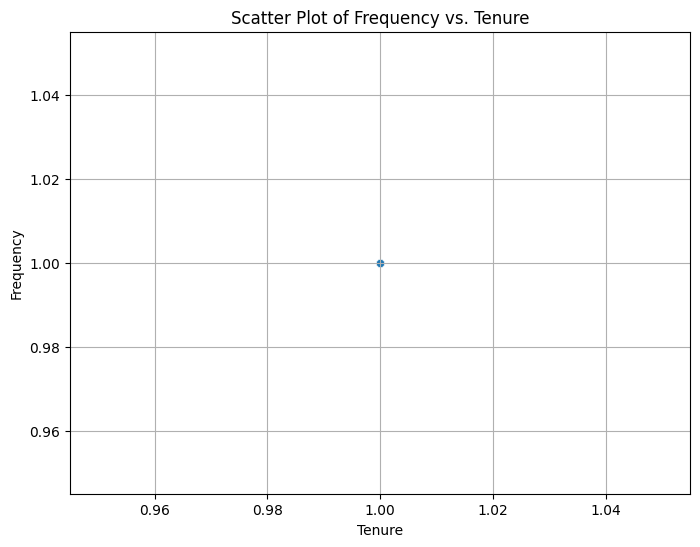

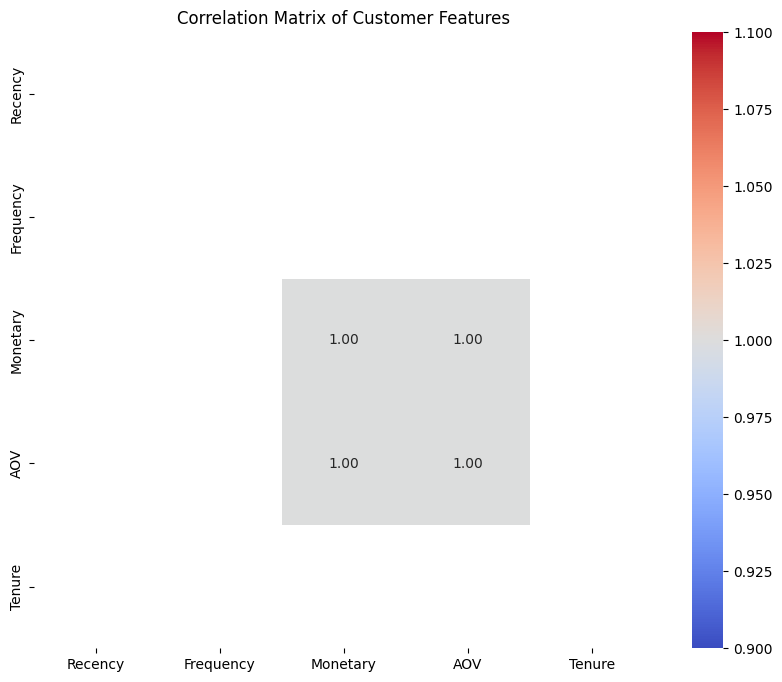

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the pairs of numerical variables for scatter plots
scatter_pairs = [
    ('Recency', 'Frequency'),
    ('Monetary', 'Frequency'),
    ('Monetary', 'Recency'),
    ('AOV', 'Monetary'),
    ('Tenure', 'Monetary'),
    ('Tenure', 'Frequency')
]

# Create scatter plots
for x_var, y_var in scatter_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=customer_features, x=x_var, y=y_var)
    plt.title(f'Scatter Plot of {y_var} vs. {x_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.grid(True)
    plt.show()

# Calculate the correlation matrix
correlation_matrix = customer_features[['Recency', 'Frequency', 'Monetary', 'AOV', 'Tenure']].corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Customer Features')
plt.show()

In [11]:
# Group by Cohort and Customer ID to find the first purchase month and purchase month for each customer
cohort_customers = df_sorted.groupby(['Cohort', 'Customer ID'])['PurchaseDate'].min().reset_index()
cohort_customers.rename(columns={'PurchaseDate': 'FirstPurchaseMonth'}, inplace=True)
cohort_customers['FirstPurchaseMonth'] = cohort_customers['FirstPurchaseMonth'].dt.to_period('M')

# Merge with the original dataframe to get all purchase months for each customer
cohort_customers = cohort_customers.merge(df_sorted[['Customer ID', 'PurchaseDate']], on='Customer ID')
cohort_customers['PurchaseMonth'] = cohort_customers['PurchaseDate'].dt.to_period('M')

# Calculate the number of months since the first purchase for each purchase
cohort_customers['MonthSinceFirstPurchase'] = (cohort_customers['PurchaseMonth'] - cohort_customers['FirstPurchaseMonth']).apply(lambda x: x.n)

# Group by Cohort and MonthSinceFirstPurchase to count unique customers (retained customers)
retention_table = cohort_customers.groupby(['FirstPurchaseMonth', 'MonthSinceFirstPurchase'])['Customer ID'].nunique().reset_index(name='RetainedCustomers')

# Create a pivot table for retention analysis
retention_pivot = retention_table.pivot_table(index='FirstPurchaseMonth', columns='MonthSinceFirstPurchase', values='RetainedCustomers')

# Calculate cohort size (number of unique customers in the first month)
cohort_size = retention_pivot.iloc[:, 0]

# Calculate retention rate
retention_matrix = retention_pivot.divide(cohort_size, axis=0)

# Display cohort size and retention table
print("Cohort Size:")
display(cohort_size)
print("\nRetention Table:")
display(retention_matrix)

Cohort Size:


,0
FirstPurchaseMonth,
2023-01,3900.0



Retention Table:


MonthSinceFirstPurchase,0
FirstPurchaseMonth,
2023-01,1.0


In [12]:
from sklearn.preprocessing import StandardScaler

# Select the RFM features
rfm_features = customer_features[['Recency', 'Frequency', 'Monetary']]

# Standardize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert the scaled features back to a DataFrame (optional, but good for clarity)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])

display(rfm_scaled_df.head())

,Recency_scaled,Frequency_scaled,Monetary_scaled
0,0.0,0.0,-0.285629
1,0.0,0.0,0.178852
2,0.0,0.0,0.558882
3,0.0,0.0,1.276716
4,0.0,0.0,-0.454531


**Reasoning**:
Apply K-Means clustering to the standardized RFM features and add the cluster labels to the customer_features DataFrame.



In [13]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (choosing 4 clusters for now)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # Added n_init
customer_features['RFM_Cluster'] = kmeans.fit_predict(rfm_scaled)

display(customer_features.head())

,Customer ID,Recency,Frequency,Monetary,AOV,Tenure,RFM_Cluster
0,1,1,1,53,53.0,1,1
1,2,1,1,64,64.0,1,3
2,3,1,1,73,73.0,1,3
3,4,1,1,90,90.0,1,0
4,5,1,1,49,49.0,1,1


In [25]:
# Analyze the characteristics of each cluster
cluster_characteristics = customer_features.groupby('RFM_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

display(cluster_characteristics)

,Recency,Frequency,Monetary
RFM_Cluster,,,
0,1.0,1.0,90.554192
1,1.0,1.0,50.498920
2,1.0,1.0,29.973585
3,1.0,1.0,70.496795


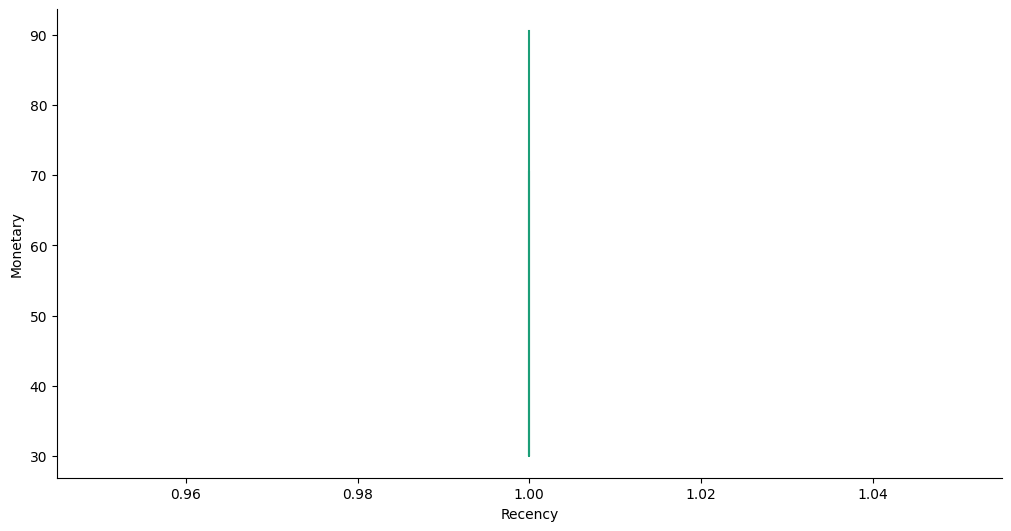

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recency']
  ys = series['Monetary']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_characteristics.sort_values('Recency', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recency')
_ = plt.ylabel('Monetary')

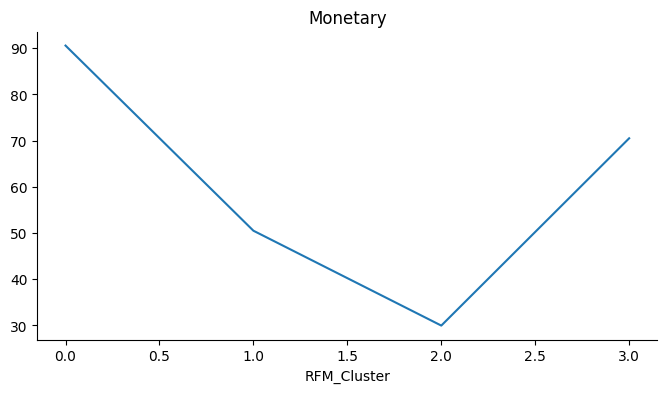

In [23]:
from matplotlib import pyplot as plt
cluster_characteristics['Monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
# Select the relevant columns for basket analysis
basket_data = df[['Customer ID', 'Item Purchased']]

# Transform the data into a one-hot encoded format
basket_one_hot = basket_data.copy()
basket_one_hot['Count'] = 1
basket_one_hot = basket_one_hot.pivot_table(index='Customer ID', columns='Item Purchased', values='Count').fillna(0)

# Convert values to boolean (True if purchased, False otherwise)
basket_one_hot = basket_one_hot.astype(bool)

display(basket_one_hot.head())

Item Purchased,Backpack,Belt,Blouse,Boots,Coat,Dress,Gloves,Handbag,Hat,Hoodie,...,Scarf,Shirt,Shoes,Shorts,Skirt,Sneakers,Socks,Sunglasses,Sweater,T-shirt
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply the Apriori algorithm to find frequent itemsets
# Setting min_support to a relatively low value since each customer likely only made one purchase in this dataset
frequent_itemsets = apriori(basket_one_hot, min_support=0.001, use_colnames=True)

# Generate association rules from the frequent itemsets
# Setting min_threshold for confidence
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Filter and display the generated association rules, focusing on key metrics
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
display(rules.head())

,antecedents,consequents,support,confidence,lift


In [19]:
from scipy.stats import pearsonr

# Hypothesis: There is no significant linear relationship between Age and Purchase Amount (Null Hypothesis)
# Alternative Hypothesis: There is a significant linear relationship between Age and Purchase Amount

# Extract the Age and 'Purchase Amount (USD)' columns
age = df['Age']
purchase_amount = df['Purchase Amount (USD)']

# Perform Pearson correlation test
correlation_coefficient, p_value = pearsonr(age, purchase_amount)

# Interpret the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.3f}")

# Determine if the result is statistically significant
alpha = 0.05
if p_value < alpha:
    print(f"Since the p-value ({p_value:.3f}) is less than the significance level ({alpha}), we reject the null hypothesis.")
    print("Conclusion: There is a significant linear relationship between Age and Purchase Amount.")
else:
    print(f"Since the p-value ({p_value:.3f}) is greater than or equal to the significance level ({alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is no significant linear relationship between Age and Purchase Amount.")

Pearson Correlation Coefficient: -0.01
P-value: 0.515
Since the p-value (0.515) is greater than or equal to the significance level (0.05), we fail to reject the null hypothesis.
Conclusion: There is no significant linear relationship between Age and Purchase Amount.


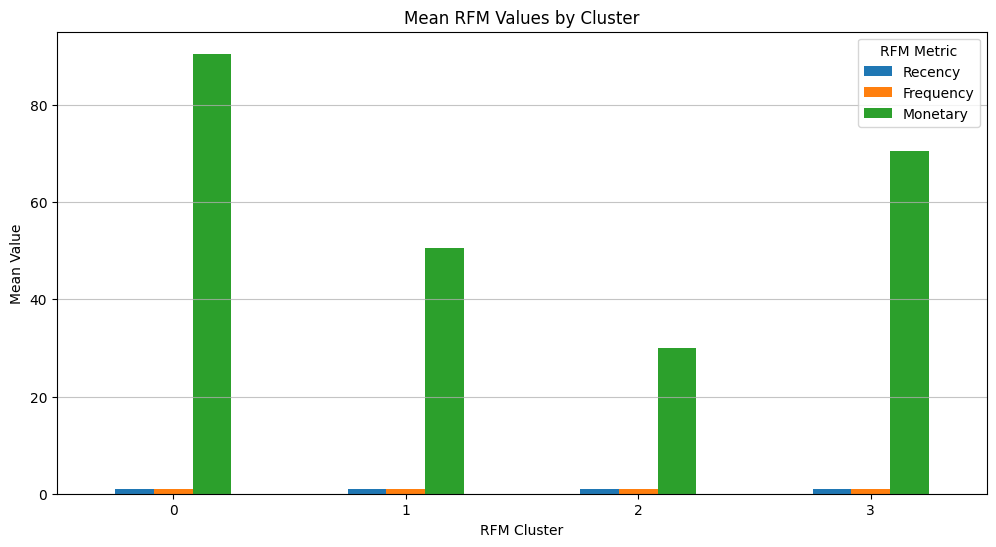

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate bar plots for RFM cluster characteristics
cluster_characteristics.plot(kind='bar', figsize=(12, 6))
plt.title('Mean RFM Values by Cluster')
plt.xlabel('RFM Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Metric')
plt.grid(axis='y', alpha=0.75)
plt.show()